# Optimization Analysis

for packgesd run this:

In [1]:
#!pip install seaborn

In [2]:
import os
import re
import glob
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [3]:
sns.set_palette("Set2")

### Introduction

In this notebook we analyze the results of hyperparameter tuning with **Optuna** and the training of the **best hyperparameter configuration**.

---

#### Part 1: Hyperparameter Sensitivity Study
- We trained **9 models**, each with a different combination of hyperparameters
- For each configuration, we ran **8 random seeds** for **4,000 episodes** 
- Goals:
  - Visualize **learning dynamics** across seeds for each configuration
  - Display **learning histograms** (mean ± std, min/max) 
  - Analyze the **influence of individual hyperparameters**
---

#### Part 2: Best Hyperparameter 
- We selected the best hyperparameters from the sensitivity study  
- Trained with **8 seeds** for **60,000 episodes**  
- Goals:
  - Assess long-term learning performance across seeds
  - Visualize mean learning curves with variability (±std, min/max) 



## Hyperparameter Sensitivity Study

In [4]:
# folder with all histories
hist_dir = "wandb_histories"

In [5]:
pattern = os.path.join(hist_dir, "ttrial_ppo_sensitivity_*_history.csv")

records = []
for path in glob.glob(pattern):
    fname = os.path.basename(path)
    m = re.match(r"ttrial_ppo_sensitivity_(\d+)-s(\d+)_history\.csv", fname)
    if m:
        trial = int(m.group(1))
        seed = int(m.group(2))
        df_tmp = pd.read_csv(path)
        df_tmp["trial"] = trial
        df_tmp["seed"] = seed
        records.append(df_tmp)

hist_df = pd.concat(records, ignore_index=True)

print("Loaded histories:", hist_df.shape)
hist_df.head()

Loaded histories: (292000, 18)


,total_reward,entropy_coef,_step,steps_total,_runtime,actor_loss,episode,critic_loss,_timestamp,std_mean,walker_2/effort,walker_1/effort,walker_0/effort,walker_0/reward,walker_2/reward,walker_1/reward,trial,seed
0,-145.972236,0.000901,0,54,1.686067,0.000000,0,0.000000,1.757237e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,2137
1,-238.990540,0.000901,1,116,2.115020,-0.107363,1,31246.970703,1.757237e+09,1.000118,NaN,NaN,NaN,NaN,NaN,NaN,5,2137
2,-328.950467,0.000901,2,216,2.538478,0.000000,2,0.000000,1.757237e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,2137
3,-274.397562,0.000901,3,278,2.838079,-0.166972,3,36791.210938,1.757237e+09,0.999472,NaN,NaN,NaN,NaN,NaN,NaN,5,2137
4,-380.206462,0.000901,4,354,3.288732,0.000000,4,0.000000,1.757237e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,2137


In [6]:
import pandas as pd

# bin episodes in steps of 100
hist_df["episode_bin"] = (hist_df["episode"] // 100) * 100

# metrics of interest
metrics = [
    "total_reward", "entropy_coef", "steps_total", "actor_loss",
    "critic_loss", "std_mean"
]

# aggregate: mean + std + min + max (per trial × bin)
agg_funcs = {}
for m in metrics:
    agg_funcs[m] = ["mean", "std", "min", "max"]

binned = (
    hist_df.groupby(["trial", "episode_bin"])
           .agg(agg_funcs)
)

# flatten multiindex column names: metric_mean, metric_std, etc.
binned.columns = [f"{m}_{stat}" for m, stat in binned.columns]
binned = binned.reset_index()

print("Binned shape:", binned.shape)
binned.head()


Binned shape: (400, 26)


,trial,episode_bin,total_reward_mean,total_reward_std,total_reward_min,total_reward_max,entropy_coef_mean,entropy_coef_std,entropy_coef_min,entropy_coef_max,...,actor_loss_min,actor_loss_max,critic_loss_mean,critic_loss_std,critic_loss_min,critic_loss_max,std_mean_mean,std_mean_std,std_mean_min,std_mean_max
0,0,0,-224.607660,142.674755,-1518.732978,298.925442,0.001875,0.000817,0.001793,0.01,...,-0.474927,3.174939,79659.470801,160734.625817,0.0,505215.31250,0.999390,0.000693,0.998279,1.001036
1,0,100,-231.153791,135.718447,-1072.256223,280.293027,0.010000,0.000000,0.010000,0.01,...,-0.393256,0.969709,64265.881602,131231.104870,0.0,477308.93750,1.000137,0.000985,0.998552,1.003026
2,0,200,-216.778141,129.439875,-834.910068,100.351242,0.010000,0.000000,0.010000,0.01,...,-1.004200,0.754614,41576.572466,87948.242110,0.0,383464.96875,1.001171,0.001497,0.998810,1.005769
3,0,300,-242.034821,157.888091,-1091.981174,273.285522,0.010000,0.000000,0.010000,0.01,...,-0.591209,0.827994,28316.037864,62426.451666,0.0,390828.50000,1.002631,0.002320,0.996530,1.007881
4,0,400,-254.626433,205.208317,-1390.260902,440.022853,0.010000,0.000000,0.010000,0.01,...,-1.008544,0.513181,27781.415396,65890.185412,0.0,423775.40625,1.004266,0.004080,0.995138,1.011738


In [7]:
def plot_trial_reward_ax(ax, trial_df, trial_id):
    # pick a color for this trial from the current palette
    color = sns.color_palette("Set2")[0]

    # mean line
    ax.plot(
        trial_df["episode_bin"],
        trial_df["total_reward_mean"],
        label="mean",
        color=color,
        linewidth=2
    )
    # std shading
    ax.fill_between(
        trial_df["episode_bin"],
        trial_df["total_reward_mean"] - trial_df["total_reward_std"],
        trial_df["total_reward_mean"] + trial_df["total_reward_std"],
        color=color,
        alpha=0.3,
        label="±1 std"
    )
    # min/max lines
    ax.plot(
        trial_df["episode_bin"],
        trial_df["total_reward_min"],
        linestyle="--",
        color=sns.color_palette("Set2")[1],
        alpha=0.8,
        label="min"
    )
    ax.plot(
        trial_df["episode_bin"],
        trial_df["total_reward_max"],
        linestyle="--",
        color=sns.color_palette("Set2")[2],
        alpha=0.8,
        label="max"
    )

    ax.set_title(f"Trial {trial_id}", fontsize=11)
    ax.set_xlabel("Episode")
    ax.set_ylabel("Total Reward")

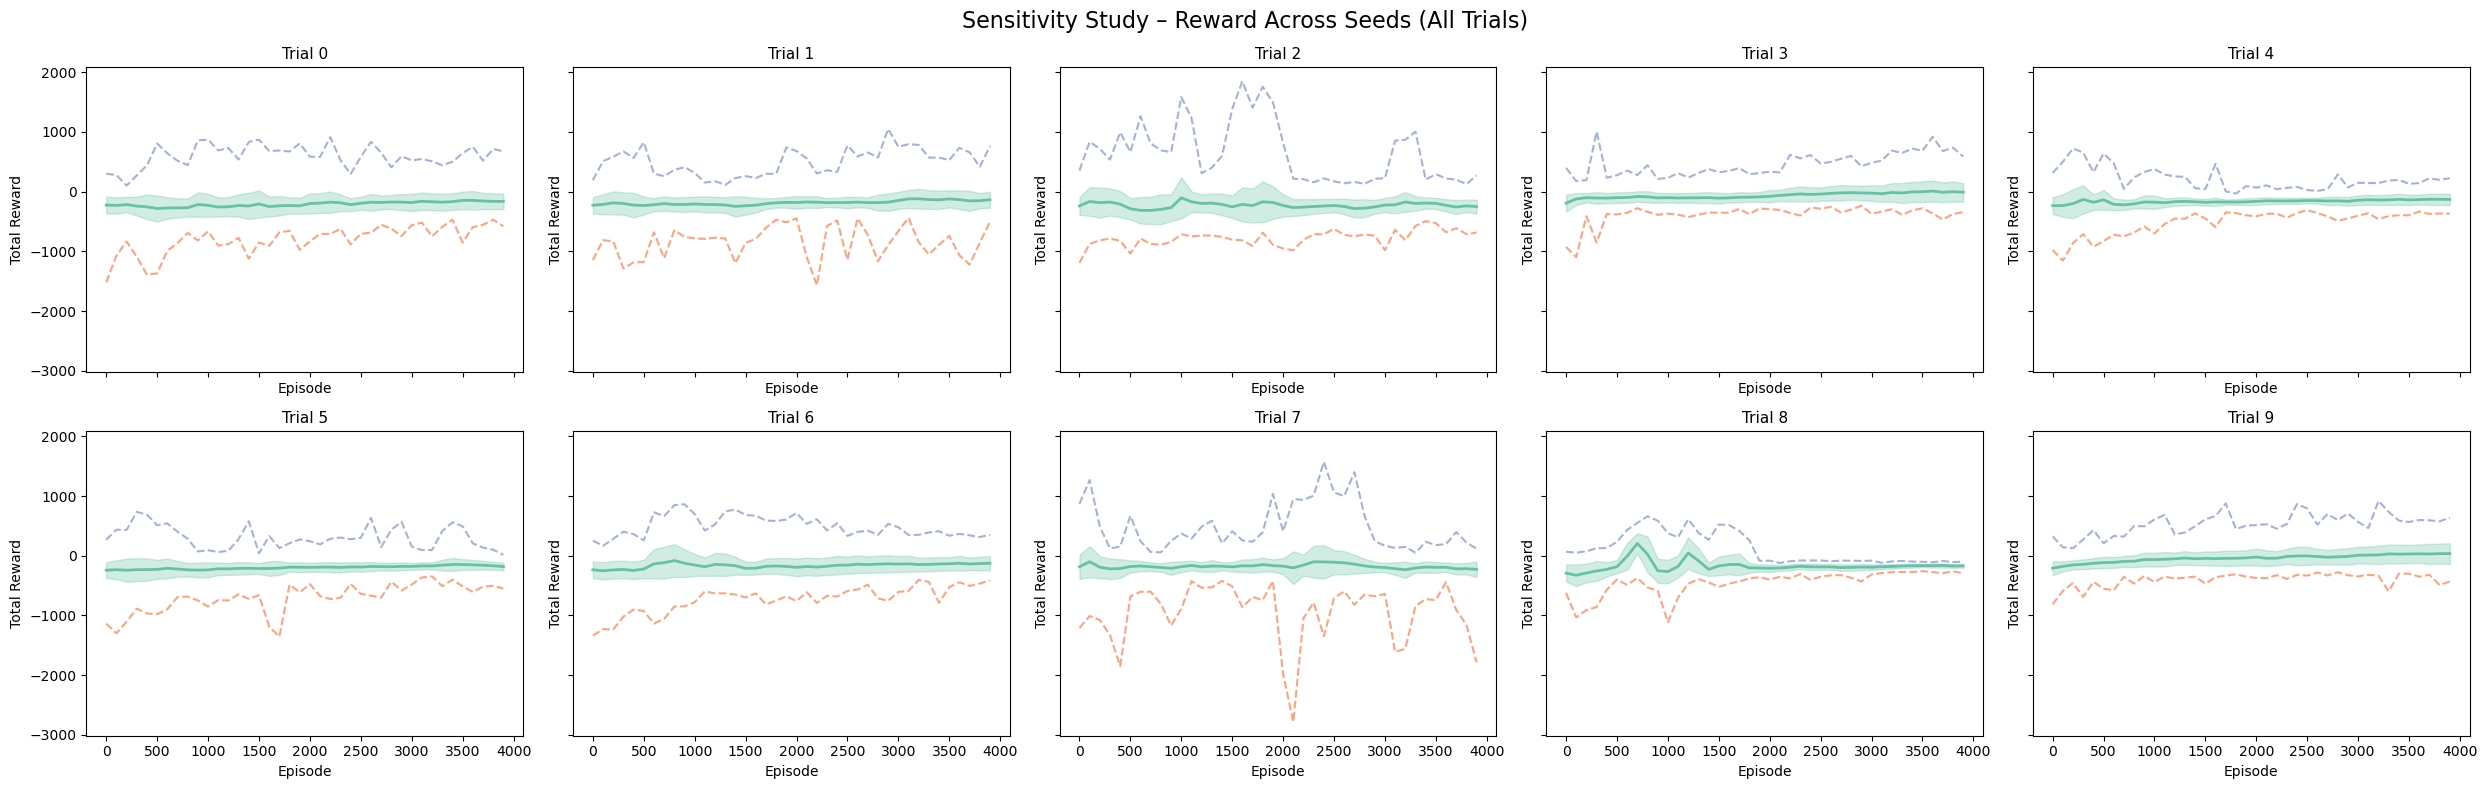

In [8]:
# get all unique trials
trial_ids = sorted(binned["trial"].unique())
n_trials = len(trial_ids)

# grid size
ncols = 5
nrows = math.ceil(n_trials / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*4), sharex=True, sharey=True)
axes = axes.flatten()

for i, trial_id in enumerate(trial_ids):
    trial_df = binned[binned["trial"] == trial_id]
    plot_trial_reward_ax(axes[i], trial_df, trial_id)

# remove empty subplots if n_trials not multiple of ncols
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Sensitivity Study – Reward Across Seeds (All Trials)", fontsize=16)
plt.tight_layout()
plt.show()

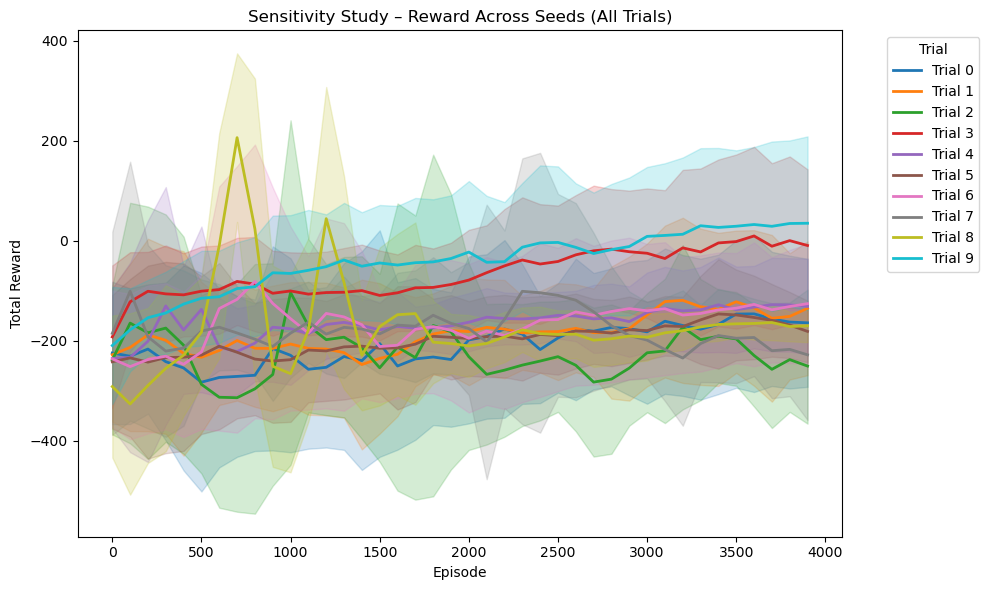

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# distinct color per trial
palette = sns.color_palette("tab10", n_colors=len(binned["trial"].unique()))

plt.figure(figsize=(10, 6))

for color, trial_id in zip(palette, sorted(binned["trial"].unique())):
    trial_df = binned[binned["trial"] == trial_id]

    # mean line
    plt.plot(
        trial_df["episode_bin"],
        trial_df["total_reward_mean"],
        label=f"Trial {trial_id}",
        color=color,
        linewidth=2
    )

    # std shading
    plt.fill_between(
        trial_df["episode_bin"],
        trial_df["total_reward_mean"] - trial_df["total_reward_std"],
        trial_df["total_reward_mean"] + trial_df["total_reward_std"],
        color=color,
        alpha=0.2
    )

plt.title("Sensitivity Study – Reward Across Seeds (All Trials)")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend(title="Trial", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


#### Hyperparameter analysis

Read the data

In [10]:
import pandas as pd

params_file = "wandb_histories/wandb_export_2025-09-08T10_27_54.283+02_00.csv"
params_df = pd.read_csv(params_file)

# keep only relevant columns
param_cols = [
    "learning_rate", "entropy_coef", "gamma", "gae_lambda", "eps_clip",
    "value_loss_coef", "ppo_epochs", "mini_batch_size", "learn_every", "max_steps"
]

print("Shape:", params_df.shape)
params_df[param_cols + ["total_reward"]].head()


Shape: (73, 48)


,learning_rate,entropy_coef,gamma,gae_lambda,eps_clip,value_loss_coef,ppo_epochs,mini_batch_size,learn_every,max_steps,total_reward
0,0.002403,0.021412,0.977656,0.960369,0.249624,0.6058,8,256,10,500,89.962417
1,0.002403,0.021412,0.977656,0.960369,0.249624,0.6058,8,256,10,500,-151.379573
2,0.002403,0.021412,0.977656,0.960369,0.249624,0.6058,8,256,10,500,-143.420460
3,0.002403,0.021412,0.977656,0.960369,0.249624,0.6058,8,256,10,500,-5.058402
4,0.002403,0.021412,0.977656,0.960369,0.249624,0.6058,8,256,10,500,48.369157


In [11]:
continuous_params = [
    "learning_rate", "gamma", "gae_lambda",
    "eps_clip", "entropy_coef", "value_loss_coef"
]
categorical_params = ["mini_batch_size", "learn_every", "ppo_epochs", "max_steps"]


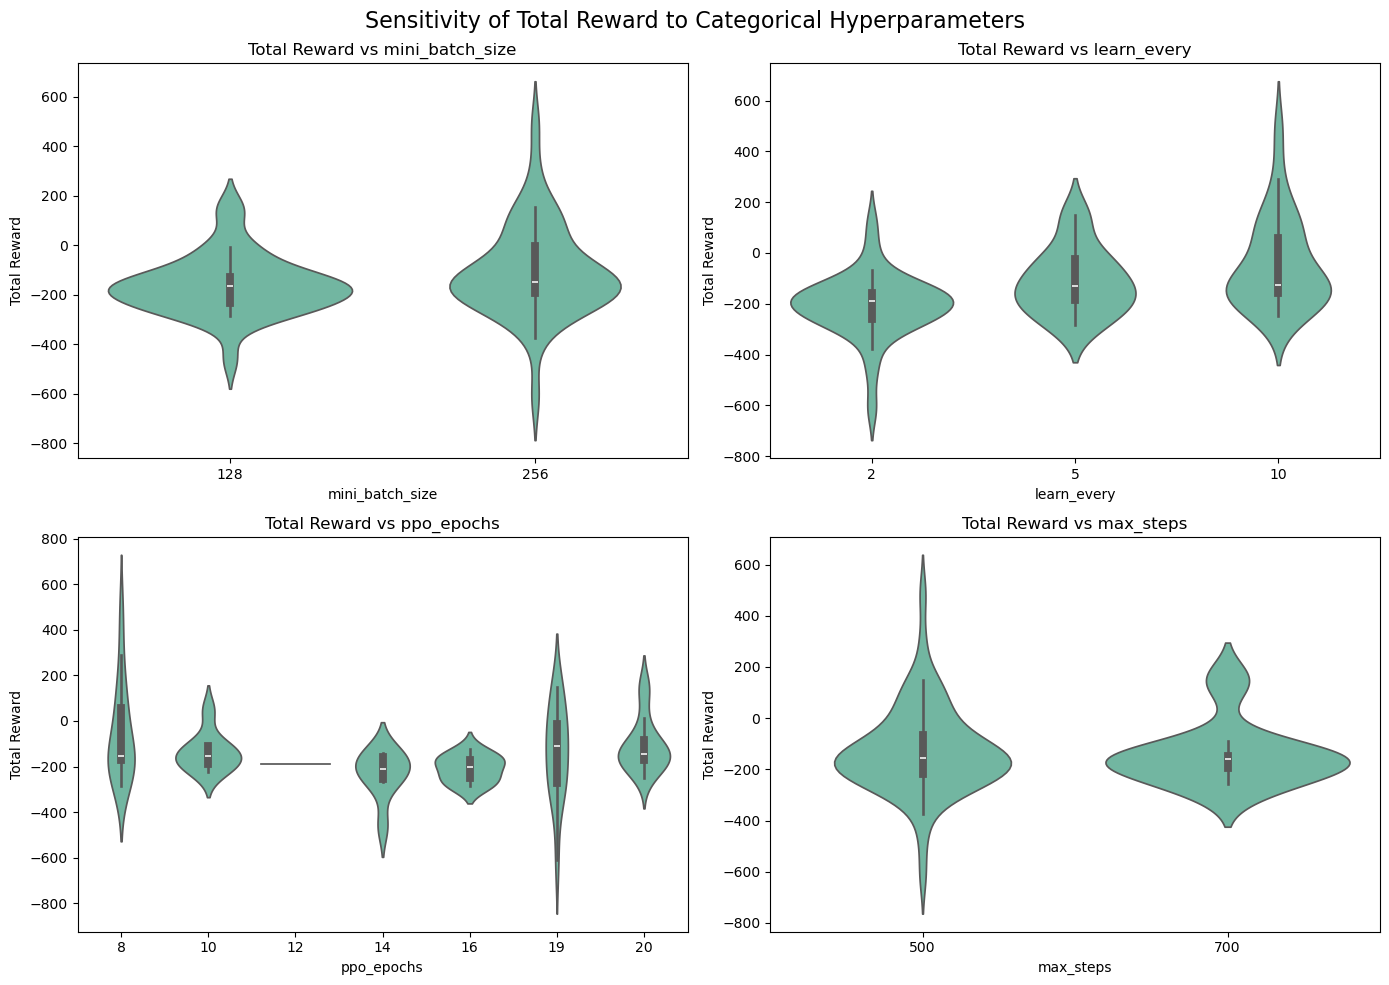

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, param in enumerate(categorical_params):
    sns.violinplot(
        data=params_df,
        x=param,
        y="total_reward",
        inner="box",
        ax=axes[i]
    )
    axes[i].set_title(f"Total Reward vs {param}", fontsize=12)
    axes[i].set_xlabel(param)
    axes[i].set_ylabel("Total Reward")

plt.suptitle("Sensitivity of Total Reward to Categorical Hyperparameters", fontsize=16)
plt.tight_layout()
plt.show()

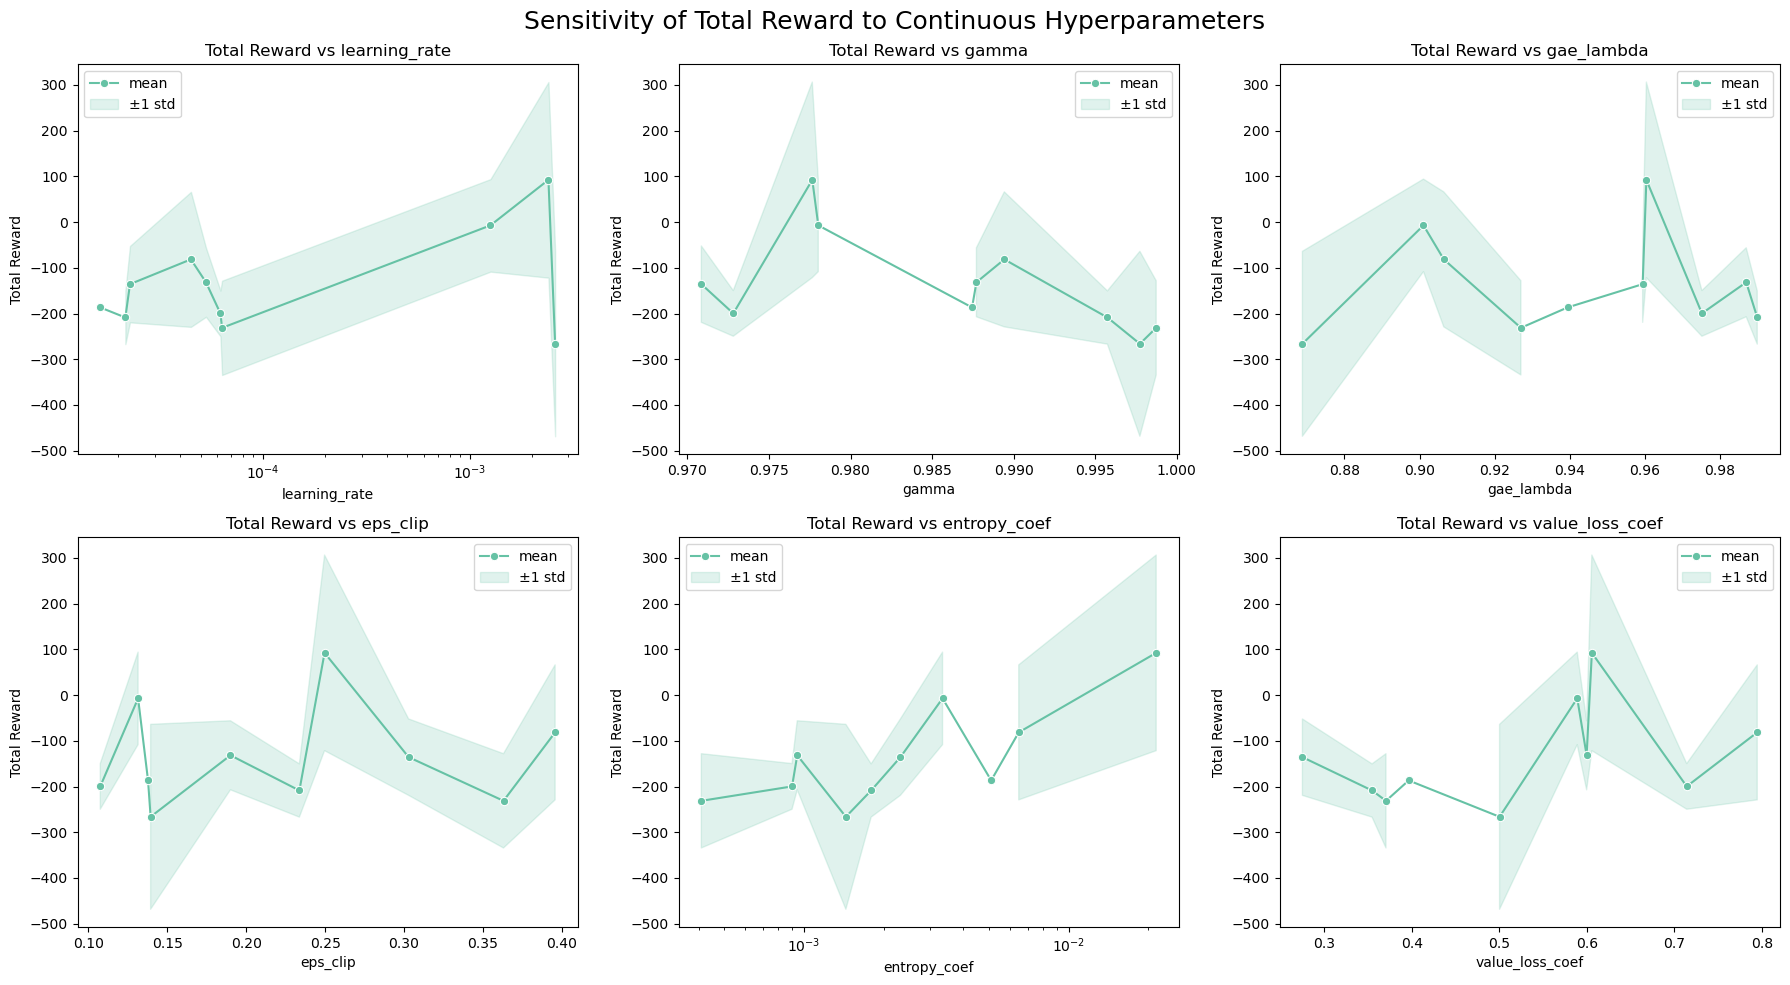

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, param in enumerate(continuous_params):
    # group by hyperparameter value, compute mean + std of reward
    grouped = (
        params_df.groupby(param)["total_reward"]
        .agg(["mean", "std"])
        .reset_index()
        .sort_values(param)
    )

    # mean line with markers
    sns.lineplot(
        data=grouped,
        x=param,
        y="mean",
        marker="o",
        ax=axes[i],
        label="mean",
        color=sns.color_palette("Set2")[0]
    )

    axes[i].fill_between(
        grouped[param],
        grouped["mean"] - grouped["std"],
        grouped["mean"] + grouped["std"],
        alpha=0.2,
        color=sns.color_palette("Set2")[0],
        label="±1 std"
    )

    # log-scale for learning_rate & entropy_coef
    if param in ["learning_rate", "entropy_coef"]:
        axes[i].set_xscale("log")

    axes[i].set_title(f"Total Reward vs {param}")
    axes[i].set_xlabel(param)
    axes[i].set_ylabel("Total Reward")
    axes[i].legend()

plt.suptitle("Sensitivity of Total Reward to Continuous Hyperparameters", fontsize=18)
plt.tight_layout()
plt.show()

In [14]:
# best hyperparameter config
best_params = {
    "value_loss_coef": 0.6058003410703234,
    "entropy_coef": 0.02141151831241083,
    "eps_clip": 0.24962360917369575,
    "gae_lambda": 0.9603689956446896,
    "gamma": 0.9776556513063028,
    "learn_every": 10,
    "learning_rate": 0.002402660514798173,
    "max_steps": 500,
    "mini_batch_size": 256,
    "ppo_epochs": 8,
}

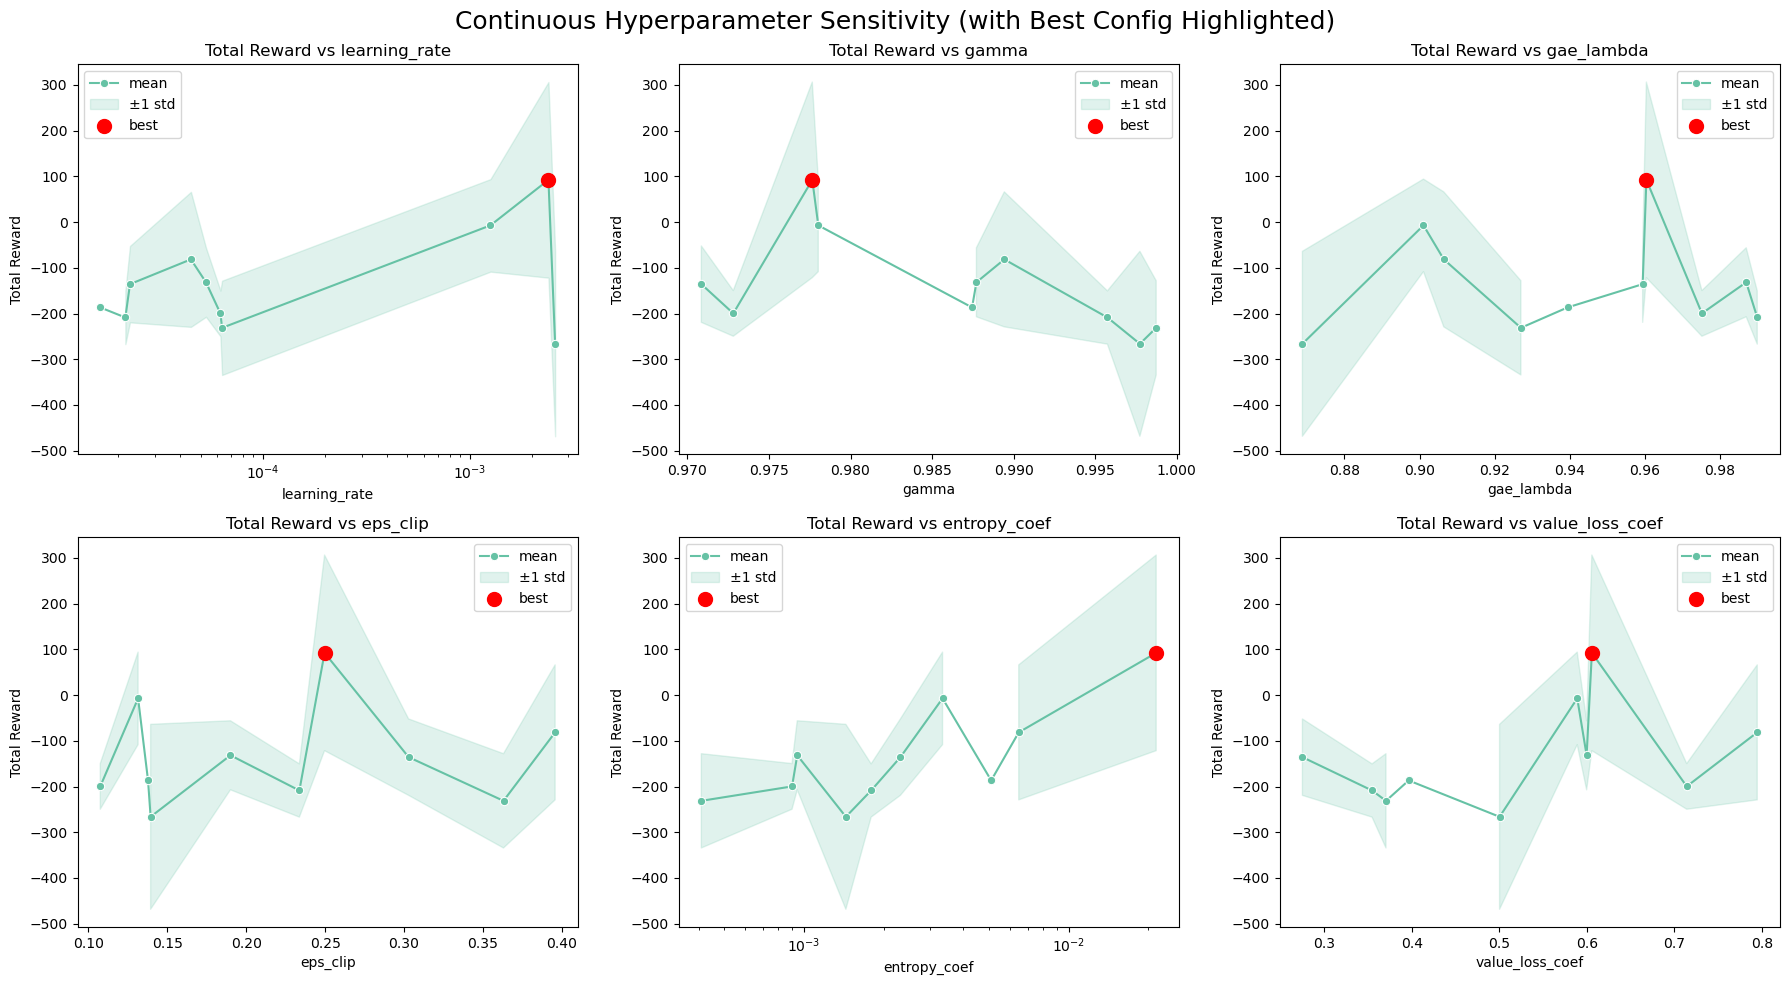

In [15]:

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, param in enumerate(continuous_params):
    grouped = (
        params_df.groupby(param)["total_reward"]
        .agg(["mean", "std"])
        .reset_index()
        .sort_values(param)
    )

    # mean line with Seaborn palette color
    sns.lineplot(
        x=param,
        y="mean",
        data=grouped,
        marker="o",
        ax=axes[i],
        label="mean",
        color=sns.color_palette("Set2")[0]
    )

    # ±1 std band
    axes[i].fill_between(
        grouped[param],
        grouped["mean"] - grouped["std"],
        grouped["mean"] + grouped["std"],
        alpha=0.2,
        color=sns.color_palette("Set2")[0],
        label="±1 std"
    )

    # highlight best param with red dot
    if param in best_params:
        best_val = best_params[param]
        idx = (grouped[param] - best_val).abs().idxmin()
        axes[i].scatter(
            grouped.loc[idx, param],
            grouped.loc[idx, "mean"],
            color="red",
            s=100,
            zorder=5,
            label="best"
        )

    # log scale for sampled log-uniform params
    if param in ["learning_rate", "entropy_coef"]:
        axes[i].set_xscale("log")

    axes[i].set_title(f"Total Reward vs {param}")
    axes[i].set_xlabel(param)
    axes[i].set_ylabel("Total Reward")
    axes[i].legend()

plt.suptitle("Continuous Hyperparameter Sensitivity (with Best Config Highlighted)", fontsize=18)
plt.tight_layout()
plt.show()


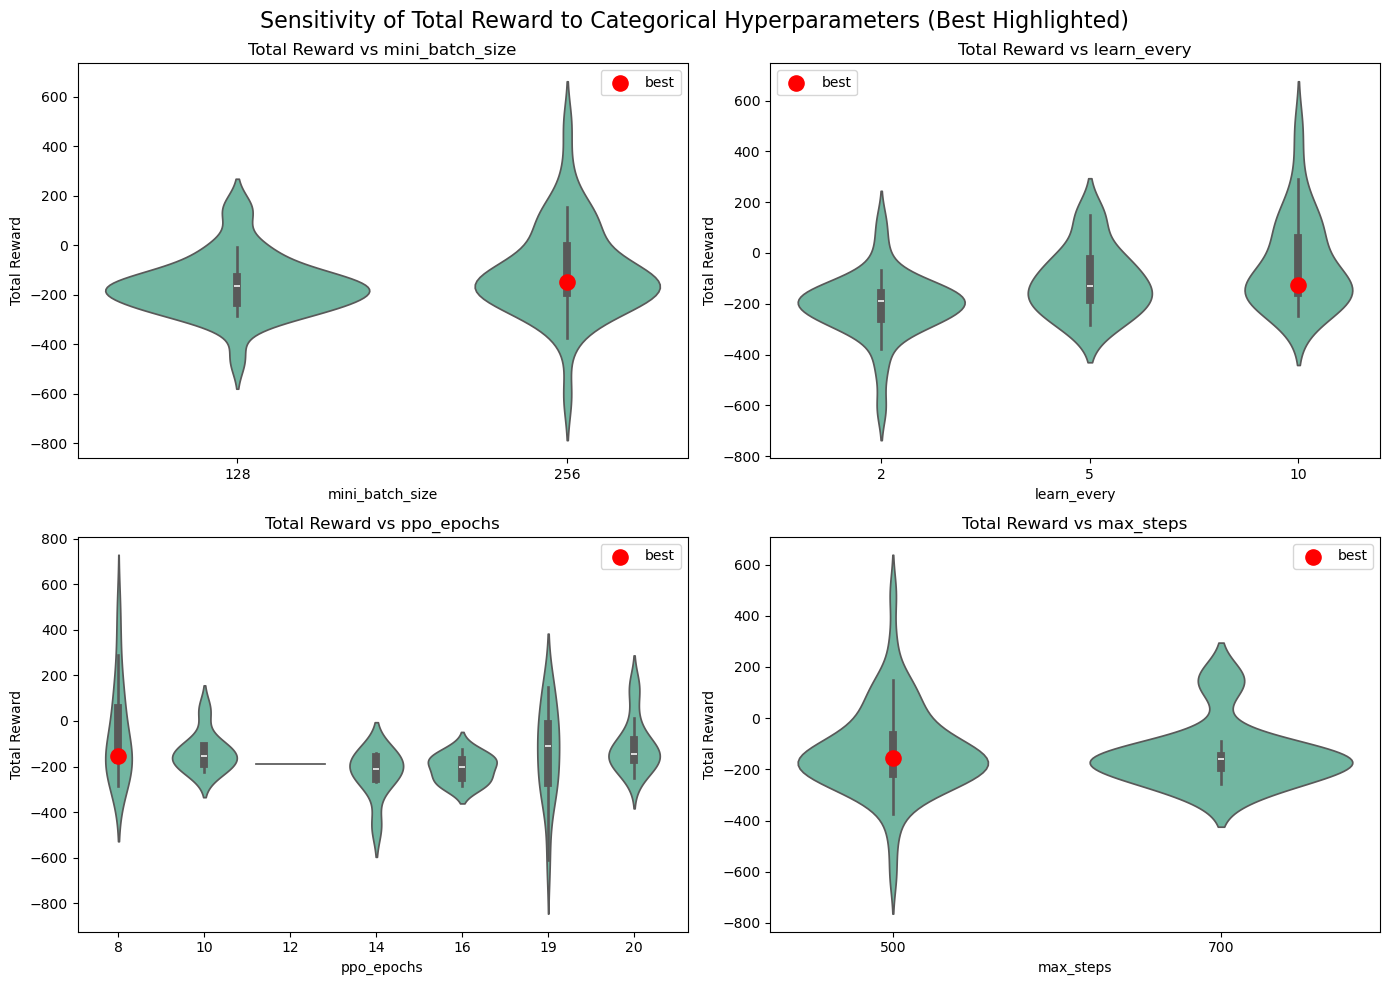

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, param in enumerate(categorical_params):
    sns.violinplot(
        data=params_df,
        x=param,
        y="total_reward",
        inner="box",
        ax=axes[i]
    )
    axes[i].set_title(f"Total Reward vs {param}")
    axes[i].set_xlabel(param)
    axes[i].set_ylabel("Total Reward")

    # highlight best value with red dot at median reward for that category
    if param in best_params:
        best_val = best_params[param]
        # subset data for that best value
        best_subset = params_df[params_df[param] == best_val]
        # compute median reward to place the marker
        median_reward = best_subset["total_reward"].median()
        axes[i].scatter(
            [list(sorted(params_df[param].unique())).index(best_val)],
            [median_reward],
            color="red",
            s=120,
            zorder=5,
            label="best"
        )
        axes[i].legend()

plt.suptitle("Sensitivity of Total Reward to Categorical Hyperparameters (Best Highlighted)", fontsize=16)
plt.tight_layout()
plt.show()


#### Observations
Best runs often used higher learning rates (0.0024) and moderate entropy coefficients (~0.02).
Gamma values close to 0.98–0.99 worked well.
Very high gamma (0.996–0.999) + low entropy often led to collapse.
Either too small or too high learning rates underperformed.


### Analysis

1. Distribution of Total Rewards
Most runs scored poorly (negative rewards), only a small portion of  runs achieved strong positive rewards.

2. Reward vs Learning Rate
Too small LR results in agents failing to learn.
Too high LR - unstable updates.

3. Reward vs Entropy Coefficient
Moderate entropy (circa 0.02) gave best rewards.
Very low entropy results in agents geting stuck in deterministic, poor policies.

4. Reward vs Gamma
Too much long-term discounting harmed performance.

5. High vs Low Performers
High performers used larger learning rates and moderate entropy.
Low performers often had extreme gamma and small learning rates.


## Best Hyperparameters Training

##### Best Hyperparameter Ranges

1. Learning Rate:
* Best runs: ~0.001 – 0.003
* Too low (<1e-4) -> agents fail to learn
* Too high (>0.01) -> unstable
2. Entropy Coefficient:
* Best runs: 0.01 – 0.03
* Too low (<0.005) - no exploration - poor policies

3. Gamma :
* Best runs: 0.975 - 0.990
* Too close to 1 (≥0.996) -> agents overemphasized long-term reward, performance collapsed

4. GAE Lambda:
* Best runs: 0.90 - 0.96
* Balances bias and variance well


In [17]:
# seeds used
best_seeds = [4, 39, 420, 444, 887, 999, 1111, 2137]

In [18]:
records = []
for s in best_seeds:
    path = f"wandb_histories/best_runs/best_ppo_s{s}_history.csv"
    df_tmp = pd.read_csv(path)
    df_tmp["seed"] = s
    records.append(df_tmp)

best_hist_df = pd.concat(records, ignore_index=True)

print("Loaded shape:", best_hist_df.shape)
best_hist_df.head()


Loaded shape: (480000, 17)


,episode,walker_1/reward,total_reward,steps_total,entropy_coef,std_mean,walker_2/effort,walker_1/effort,walker_2/reward,_timestamp,_step,actor_loss,critic_loss,_runtime,walker_0/reward,walker_0/effort,seed
0,0,NaN,-206.945618,63.0,0.021412,NaN,NaN,NaN,NaN,1.757398e+09,0,0.0,0.0,2.513977,NaN,NaN,4
1,1,NaN,-383.186494,119.0,0.021412,NaN,NaN,NaN,NaN,1.757398e+09,1,0.0,0.0,2.767788,NaN,NaN,4
2,2,NaN,-116.277407,180.0,0.021412,NaN,NaN,NaN,NaN,1.757398e+09,2,0.0,0.0,2.998284,NaN,NaN,4
3,3,NaN,-157.803719,245.0,0.021412,NaN,NaN,NaN,NaN,1.757398e+09,3,0.0,0.0,3.256340,NaN,NaN,4
4,4,NaN,-294.562932,302.0,0.021412,NaN,NaN,NaN,NaN,1.757398e+09,4,0.0,0.0,3.472527,NaN,NaN,4


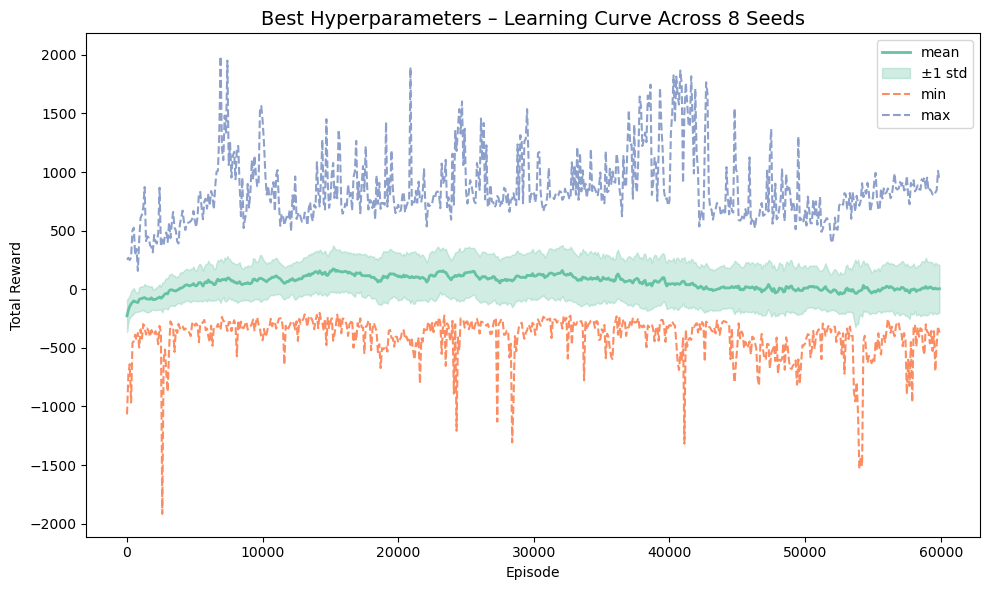

In [19]:
# --- Bin episodes into 100-step bins
best_hist_df["episode_bin"] = (best_hist_df["episode"] // 100) * 100

# --- Aggregate across seeds
agg = (
    best_hist_df.groupby("episode_bin")["total_reward"]
    .agg(["mean", "std", "min", "max"])
    .reset_index()
)

# --- Plot
plt.figure(figsize=(10,6))

# mean line
sns.lineplot(
    x="episode_bin",
    y="mean",
    data=agg,
    linewidth=2,
    label="mean",
    color="C0"
)

# ±1 std band
plt.fill_between(
    agg["episode_bin"],
    agg["mean"] - agg["std"],
    agg["mean"] + agg["std"],
    alpha=0.3,
    color="C0",
    label="±1 std"
)

# min/max dashed
sns.lineplot(
    x="episode_bin",
    y="min",
    data=agg,
    linestyle="--",
    color="C1",
    label="min"
)
sns.lineplot(
    x="episode_bin",
    y="max",
    data=agg,
    linestyle="--",
    color="C2",
    label="max"
)

plt.title("Best Hyperparameters – Learning Curve Across 8 Seeds", fontsize=14)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.tight_layout()
plt.show()
